In [10]:
import pandas as pd
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models
from epam.torch_common import pick_device, parameter_count_of_model

In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nickname = 'small'

max_length=500
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
    train_history = burrito.train(epochs=epochs)
    best_val_loss = train_history['val_loss'].min()
    # save model to models/ directory
    torch.save(model_instance.state_dict(), f"../models/{model_name}.pt")

    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

train_dataset_3, val_dataset_3 = data_of_nickname(val_nickname, kmer_length=3)
train_dataset_5, val_dataset_5 = data_of_nickname(val_nickname, kmer_length=5)
    
model_instances_3 = {
    "cnn_sml": models.CNNModel(train_dataset_3, embedding_dim=6, num_filters=14, kernel_size=7, dropout_rate=0.0),
    "cnn_med": models.CNNModel(train_dataset_3, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1),
    "cnn_lrg": models.CNNModel(train_dataset_3, embedding_dim=7, num_filters=19, kernel_size=11, dropout_rate=0.3),
    }

model_instances_5 = {
    "fivemer": models.FivemerModel(train_dataset_5),
    "shmoof": models.SHMoofModel(train_dataset_5),
}
    
comparison_df = \
    pd.concat([ comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
            ])
comparison_df["val_nickname"] = val_nickname

comparison_df
    

	Training cnn_sml...


Epoch:  36%|███▌      | 36/100 [03:59<07:05,  6.65s/it, loss_diff=2.404e-06, lr=3.2e-5]  


	Training cnn_med...


Epoch:  33%|███▎      | 33/100 [04:27<09:04,  8.12s/it, loss_diff=3.592e-06, lr=3.2e-5]  


	Training cnn_lrg...


Epoch:  31%|███       | 31/100 [04:37<10:18,  8.96s/it, loss_diff=1.934e-06, lr=3.2e-5]  


	Training fivemer...


Epoch:  29%|██▉       | 29/100 [00:32<01:19,  1.12s/it, loss_diff=5.445e-08, lr=3.2e-5]  


	Training shmoof...


Epoch:  45%|████▌     | 45/100 [00:51<01:02,  1.14s/it, loss_diff=-1.53e-07, lr=3.2e-5]  


,model_name,model,parameter_count,val_loss,val_nickname
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.055614,small
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.055397,small
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.055455,small
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055734,small
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.055743,small


In [5]:
tang_df = pd.read_csv("/Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv", index_col=0).reset_index(drop=True)

# only keep rows where parent is different than child
tang_df = tang_df[tang_df["parent"] != tang_df["child"]]
tang_dataset_3 = framework.SHMoofDataset(tang_df, kmer_length=3, max_length=max_length)
tang_dataset_5 = framework.SHMoofDataset(tang_df, kmer_length=5, max_length=max_length)
tang_dataset_3.to(device)
tang_dataset_5.to(device)

In [6]:
def calculate_loss(model, dataset):
    model.eval()
    model.to(device)
    burrito = framework.Burrito(dataset, dataset, model, verbose=False, **burrito_params)
    loss = burrito.evaluate()
    return loss

comparison_df["tang_loss"] = None
for model_name, model_instance in model_instances_3.items():
    comparison_df.loc[comparison_df["model_name"] == model_name, "tang_loss"] = calculate_loss(model_instance, tang_dataset_3)

for model_name, model_instance in model_instances_5.items():
    comparison_df.loc[comparison_df["model_name"] == model_name, "tang_loss"] = calculate_loss(model_instance, tang_dataset_5)

In [7]:
comparison_df

,model_name,model,parameter_count,val_loss,val_nickname,tang_loss
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.055614,small,0.089749
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.055397,small,0.089547
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.055455,small,0.089314
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055734,small,0.089921
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.055743,small,0.090392


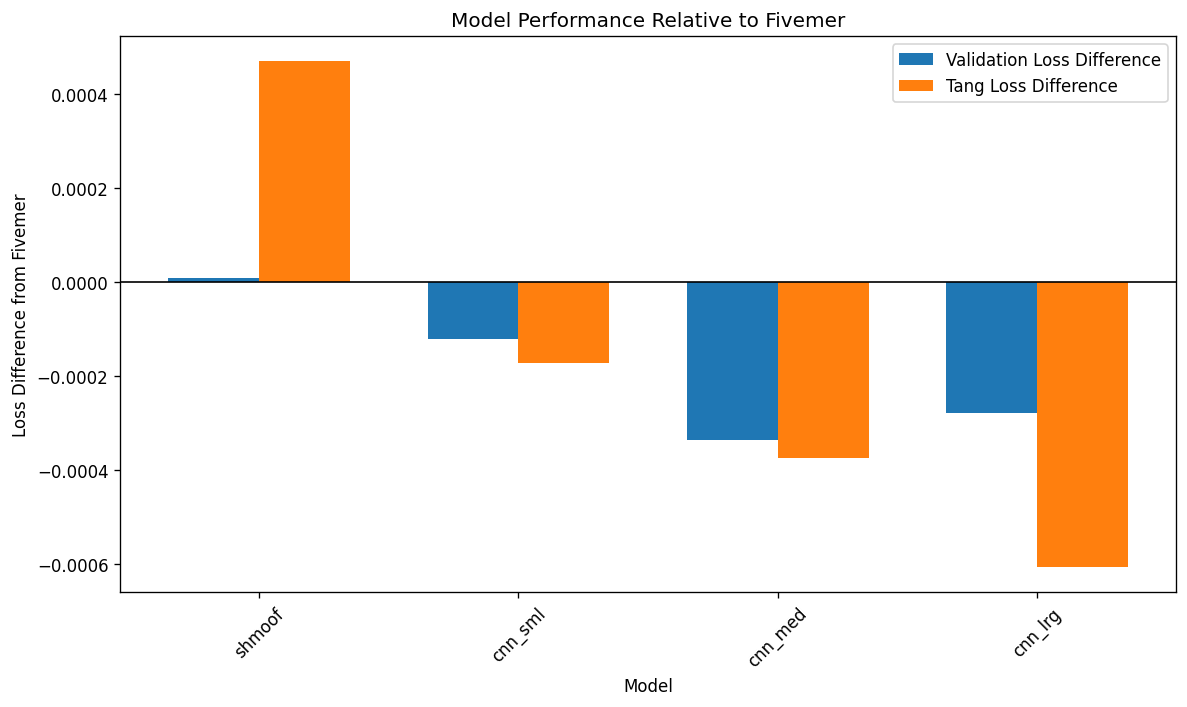

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = comparison_df

# Calculate the difference from the fivemer model for val_loss and tang_loss
fivemer_val_loss = df[df['model_name'] == 'fivemer']['val_loss'].values[0]
fivemer_tang_loss = df[df['model_name'] == 'fivemer']['tang_loss'].values[0]

df['val_loss_diff'] = df['val_loss'] - fivemer_val_loss
df['tang_loss_diff'] = df['tang_loss'] - fivemer_tang_loss

# Filter out the fivemer model and reorder to have shmoof first
df = df[df['model_name'] != 'fivemer']
df = df.sort_values(by='model_name', ascending=False)  # This assumes 'shmoof' is alphabetically last

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df))

# Creating offset for the second bar
offset = bar_width / 2

bar1 = ax.bar(index - offset, df['val_loss_diff'], bar_width, label='Validation Loss Difference')
bar2 = ax.bar(index + offset, df['tang_loss_diff'], bar_width, label='Tang Loss Difference')

ax.set_xlabel('Model')
ax.set_ylabel('Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.legend()
ax.axhline(0, color='black', linewidth=1)  # Add x-axis line

plt.xticks(index, df['model_name'], rotation=45)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


NameError: name 'final_df' is not defined

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_58161/2271961537.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")


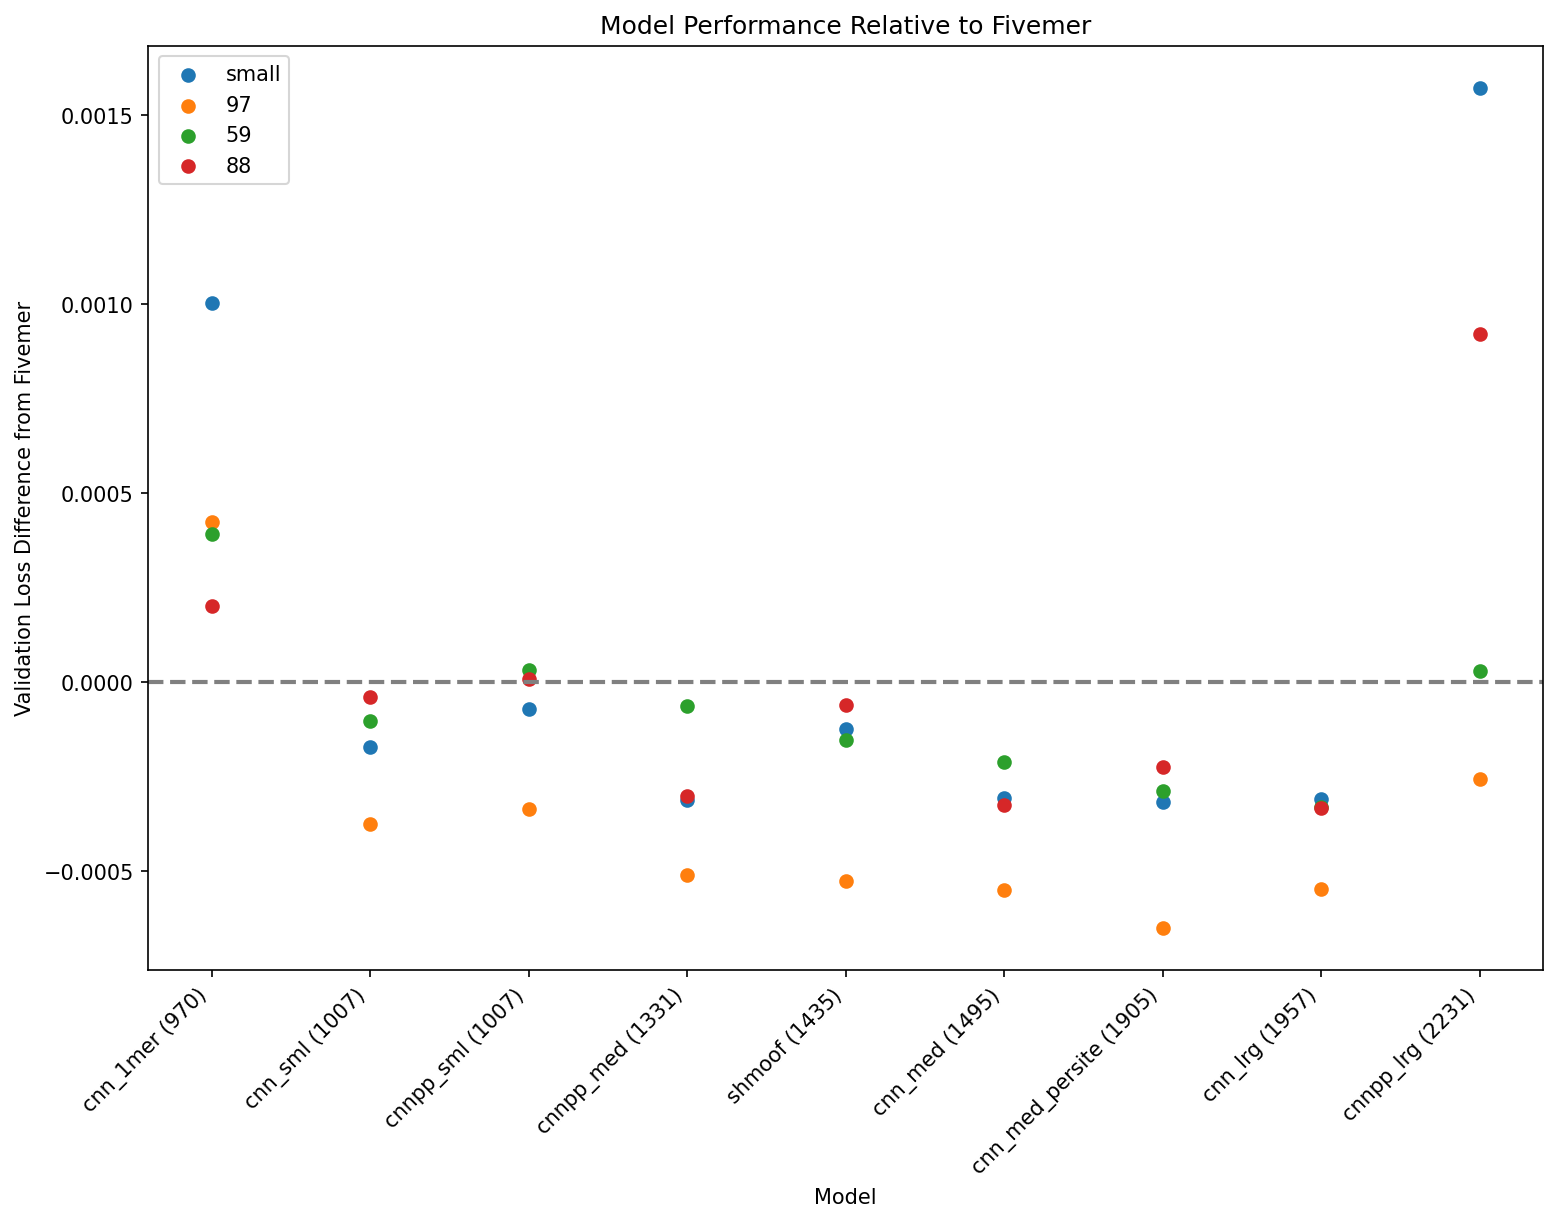

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df 

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
model_to_xlabel_str = {}
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model_name'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            model_label = f"{row['model_name']} ({row['parameter_count']})"
            model_to_xlabel_str[row['model_name']] = model_label
            loss_diffs.append({'val_nickname': nickname, 'model_name': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame and sort by parameter count
loss_diff_df = pd.DataFrame(loss_diffs)
loss_diff_df = loss_diff_df.sort_values(by='parameter_count')

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['model_name'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Model')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")
ax.legend()
plt.show()


In [ ]:
final_df

,val_nickname,model_name,model,parameter_count,val_loss
0,59,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.058132
1,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.058022
2,59,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.057902
3,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058234
4,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.058080
5,88,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.050669
6,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050384
7,88,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.050376
8,88,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.050709
9,88,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.050648
